In [1]:
# === 1. Montar Google Drive ===
from google.colab import drive
drive.mount('/content/drive')

# === 2. Cargar datasets desde la carpeta MLOPs ===
import pandas as pd

path = "/content/drive/MyDrive/MLOPs/"

original = pd.read_csv(path + "power_tetouan_city_original.csv")
modified = pd.read_csv(path + "power_tetouan_city_modified.csv")
after_eda = pd.read_csv(path + "power_tetouan_city_after_EDA.csv")


# === 3. Verificar carga exitosa ===
print("Dataset original:", original.shape)
print("Dataset modificado:", modified.shape)
print("Dataset after_eda:", after_eda.shape)


# Mostrar las primeras filas
display(original.head())
display(modified.head())
display(after_eda.head())

Mounted at /content/drive
Dataset original: (52416, 9)
Dataset modificado: (53464, 10)
Dataset after_eda: (52416, 13)


,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
1,1/1/2017 0:10,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2,1/1/2017 0:20,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


,DateTime,Temperature,Humidity,Wind Speed,general diffuse flows,diffuse flows,Zone 1 Power Consumption,Zone 2 Power Consumption,Zone 3 Power Consumption,mixed_type_col
0,1/1/2017 0:00,6.559,73.8,0.083,0.051,NaN,34055.6962,16128.87538,20240.96386,624
1,1/1/2017 0:10,6.414,74.5,0.083,0.07,0.085,29814.68354,19375.07599,20131.08434,811
2,1/1/2017 0:20,6.313,74.5,0.08,0.062,0.1,29128.10127,19006.68693,19668.43373,unknown
3,1/1/2017 0:30,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711,bad
4,1/1/2017 0:40,5.921,75.7,0.081,0.048,0.085,27335.6962,17872.34043,18442.40964,879


,DateTime,temp,hum,wind,gen_diffuse_flows,diffuse_flows,z1_power_cons,z2_power_cons,z3_power_cons,hour,day_of_week,month,day
0,2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386,0,6,1,1
1,2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434,0,6,1,1
2,2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373,0,6,1,1
3,2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711,0,6,1,1
4,2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964,0,6,1,1


In [2]:
list(after_eda.columns)

['DateTime',
 'temp',
 'hum',
 'wind',
 'gen_diffuse_flows',
 'diffuse_flows',
 'z1_power_cons',
 'z2_power_cons',
 'z3_power_cons',
 'hour',
 'day_of_week',
 'month',
 'day']

#1) Carga y split

In [3]:
# === Configuración base ===
import pandas as pd, numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Cargar dataset
#df = pd.read_csv("/mnt/data/power_tetouan_city_after_EDA.csv")
df = after_eda
# Variable objetivo y features
target = "z1_power_cons"
X = df.drop(columns=[target, "DateTime"], errors="ignore")
y = df[target]

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(X_train.shape, X_test.shape)
X.head(3)


(41932, 11) (10484, 11)


,temp,hum,wind,gen_diffuse_flows,diffuse_flows,z2_power_cons,z3_power_cons,hour,day_of_week,month,day
0,6.559,73.8,0.083,0.051,0.119,16128.87538,20240.96386,0,6,1,1
1,6.414,74.5,0.083,0.070,0.085,19375.07599,20131.08434,0,6,1,1
2,6.313,74.5,0.080,0.062,0.100,19006.68693,19668.43373,0,6,1,1


# 2) Modelos baseline (con pipelines)

In [4]:
# === Modelos baseline con pipelines  ===
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# Columnas numéricas a escalar para modelos lineales
num_features = X.columns.tolist()
prep = ColumnTransformer([("num", StandardScaler(), num_features)])

models = {
    "Linear": Pipeline([("prep", prep), ("model", LinearRegression())]),
    "Ridge":  Pipeline([("prep", prep), ("model", Ridge(alpha=1.0))]),
    "Lasso":  Pipeline([("prep", prep), ("model", Lasso(alpha=1e-3, max_iter=5000))]),
    "RF":     Pipeline([
                 ("prep", "passthrough"),
                 ("model", RandomForestRegressor(
                     n_estimators=120, max_depth=12, random_state=42, n_jobs=-1
                 ))
             ]),
}

rows = []
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    pred = pipe.predict(X_test)
    mae  = mean_absolute_error(y_test, pred)
    # ⬇️ RMSE SIN 'squared=False' (compatibilidad versiones)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    r2   = r2_score(y_test, pred)
    rows.append([name, mae, rmse, r2])

baseline = (
    pd.DataFrame(rows, columns=["Modelo", "MAE", "RMSE", "R²"])
      .sort_values("R²", ascending=False)
      .reset_index(drop=True)
)
baseline


,Modelo,MAE,RMSE,R²
0,RF,650.645827,932.594082,0.982776
1,Linear,2041.038522,2626.267358,0.863405
2,Lasso,2041.038767,2626.267375,0.863405
3,Ridge,2041.043855,2626.268904,0.863405


## 🧾 Resumen — Modelos baseline (pipelines)

**Dataset:** `power_tetouan_city_after_EDA.csv`  
**Target:** `z1_power_cons`

---

### 📊 Métricas (test)

| Modelo        | MAE     | RMSE    | R²      |
|----------------|---------|---------|---------|
| **Random Forest**  | 650.65  | 932.59  | **0.9828** |
| Linear         | 2041.04 | 2626.27 | 0.8634 |
| Lasso          | 2041.04 | 2626.27 | 0.8634 |
| Ridge          | 2041.04 | 2626.27 | 0.8634 |

> 📐 **RMSE = √MSE** (compatibilidad de versión)

---

### 🔍 Interpretación breve

- **Random Forest (RF)** es el mejor baseline (**R² = 98.28 %**, errores más bajos); captura **no linealidades**.  
- Los modelos lineales (Linear / Ridge / Lasso) rinden igual → la relación base es más **lineal** y/o hay **colinealidad** entre *features*.  
- El alto **R²** indica que `z2_power_cons` y `z3_power_cons` aportan **fuerte señal contemporánea**.

---

### ✅ Conclusiones

- Adoptar **Random Forest** como modelo baseline de la **Fase 1**.  
- Los modelos lineales sirven como **línea base explicativa**, pero con menor desempeño predictivo.

---

### 🧩 Siguientes pasos

- Realizar *tuning* del modelo RF (`n_estimators`, `max_depth`, `min_samples_*`).  
- Evaluar **importancia de variables** (*Feature Importance* o *Permutation*).  
- Si el caso es **pronóstico futuro**, crear *lags* (`t-1`, `t-2`, …) y aplicar **TimeSeriesSplit**.  
- Registrar experimentos en **MLflow** y versionar con **DVC**.

# 3) Ajuste rápido de hiperparámetros

In [5]:
# ================================================
# 3) Ajuste rápido de hiperparámetros (CORREGIDO + RÁPIDO)
# Requisitos previos en el notebook:
#   - df cargado desde power_tetouan_city_after_EDA.csv
#   - target = "z1_power_cons"
#   - X = df.drop(columns=[target, "DateTime"], errors="ignore"); y = df[target]
#   - X_train, X_test, y_train, y_test ya definidos (train_test_split)
#   - prep = ColumnTransformer([("num", StandardScaler(), X.columns.tolist())])
# ================================================

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd

# ---------- ⚡ TRUCO DE RENDIMIENTO EN COLAB ----------
# Submuestreo SOLO para el tuning (no para la evaluación final)
max_sample = min(20000, len(X_train))  # ajusta a 10k/15k si quieres aún más rápido
X_train_s = X_train.sample(max_sample, random_state=42)
y_train_s = y_train.loc[X_train_s.index]

# ---------- RANDOM FOREST: búsqueda aleatoria (más rápida que grid) ----------
rf_pipe = Pipeline([
    ("prep", "passthrough"),  # RF no necesita escalado
    ("model", RandomForestRegressor(random_state=42, n_jobs=-1))
])

rf_dist = {
    "model__n_estimators": [100, 140, 180],
    "model__max_depth": [10, 14, 18, None],
    "model__min_samples_split": [2, 5, 10],
    "model__min_samples_leaf": [1, 2, 4]
}

rf_search = RandomizedSearchCV(
    rf_pipe,
    param_distributions=rf_dist,
    n_iter=10,              # reduce/eleva para controlar tiempo
    cv=2,                   # 2-fold para acelerar
    scoring="r2",
    n_jobs=-1,
    verbose=0,
    random_state=42
)
rf_search.fit(X_train_s, y_train_s)
rf_best = rf_search.best_estimator_

# ---------- RIDGE: grid pequeño (se beneficia de escalado) ----------
ridge_pipe = Pipeline([
    ("prep", prep),
    ("model", Ridge())
])

ridge_grid = {"model__alpha": [0.1, 1.0, 10.0]}
ridge_search = GridSearchCV(
    ridge_pipe, ridge_grid,
    cv=2, scoring="r2", n_jobs=-1, verbose=0
)
ridge_search.fit(X_train_s, y_train_s)
ridge_best = ridge_search.best_estimator_

# ---------- Función de evaluación (compatibilidad: sin 'squared=False') ----------
def eval_pipe(pipe, X_te, y_te):
    y_pr = pipe.predict(X_te)
    mae  = mean_absolute_error(y_te, y_pr)
    rmse = np.sqrt(mean_squared_error(y_te, y_pr))  # RMSE = sqrt(MSE)
    r2   = r2_score(y_te, y_pr)
    return mae, rmse, r2

# Evaluación final en el conjunto de test completo
rf_mae, rf_rmse, rf_r2 = eval_pipe(rf_best, X_test, y_test)
rd_mae, rd_rmse, rd_r2 = eval_pipe(ridge_best, X_test, y_test)

summary = (
    pd.DataFrame([
        {"Modelo": "RandomForest (tuned)", "MAE": rf_mae, "RMSE": rf_rmse, "R²": rf_r2,
         "Best Params": rf_search.best_params_},
        {"Modelo": "Ridge (tuned)", "MAE": rd_mae, "RMSE": rd_rmse, "R²": rd_r2,
         "Best Params": ridge_search.best_params_},
    ])
    .sort_values("R²", ascending=False)
    .reset_index(drop=True)
)

# Formato bonito
def _fmt(df_):
    out = df_.copy()
    out["MAE"]  = out["MAE"].map(lambda v: f"{v:,.2f}")
    out["RMSE"] = out["RMSE"].map(lambda v: f"{v:,.2f}")
    out["R²"]   = out["R²"].map(lambda v: f"{v:.3f}")
    return out

print("✅ Ajuste rápido completado (submuestreo para tuning y CV=2).")
display(_fmt(summary[["Modelo","MAE","RMSE","R²"]]))
print("\n🔧 Hiperparámetros óptimos:")
summary[["Modelo","Best Params"]]


✅ Ajuste rápido completado (submuestreo para tuning y CV=2).


,Modelo,MAE,RMSE,R²
0,RandomForest (tuned),548.17,834.14,0.986
1,Ridge (tuned),"2,041.77","2,627.07",0.863



🔧 Hiperparámetros óptimos:


,Modelo,Best Params
0,RandomForest (tuned),"{'model__n_estimators': 180, 'model__min_sampl..."
1,Ridge (tuned),{'model__alpha': 1.0}


## 🔎 Análisis del “Ajuste rápido de hiperparámetros”

**Setup:** tuning con submuestreo de *train*, `cv=2` (rápido); evaluación final en *test* completo.  
**Target:** `z1_power_cons`

---

### 📊 Resultados

| Modelo                | MAE     | RMSE    | R²      | Observación |
|------------------------|---------|---------|---------|--------------|
| **RandomForest (tuned)** | 548.17  | 834.14  | **0.986** | Mejor desempeño |
| Ridge (tuned)         | 2,041.77 | 2,627.07 | 0.863 | Igual que baseline (α óptimo = 1.0) |

**Hiperparámetros óptimos (RF):** `n_estimators ≈ 180`, `min_samples_*` y `max_depth`, seleccionados por búsqueda aleatoria.  
**Hiperparámetros óptimos (Ridge):** `alpha = 1.0`

---

### 🧠 Interpretación

- **Random Forest (RF)** mejora al baseline (~MAE −15.7%, RMSE −10.6%, R² +0.003 vs. RF sin tuning).  
  → El modelo se beneficia de **más árboles/profundidad** y **umbrales de división ajustados**, capturando **no linealidades e interacciones**.  
- **Ridge no mejora:** el espacio de hiperparámetros confirma que la **regularización** no aporta ganancia adicional; la frontera lineal sigue limitada frente a RF.  
- **R² = 0.986** indica **altísima explicación** del consumo de Zona 1 con las *features* actuales (incluyen `z2_power_cons` y `z3_power_cons` del mismo timestamp).

---

### ⚠️ Consideraciones

- El tuning usó **submuestreo** y `cv=2` para acelerar; resultados estables, aunque ampliar **CV o espacio de búsqueda** podría mejorar algunas décimas.  
- Si el objetivo es **pronóstico a futuro**, construir *lags* y validar con **TimeSeriesSplit**, evitando depender de valores contemporáneos de otras zonas.

---

### ✅ Siguientes pasos sugeridos

1. **Validación robusta:** usar `TimeSeriesSplit(n_splits=5)` y una búsqueda más amplia (`n_iter ↑`).  
2. **Importancia de variables:** aplicar `permutation_importance` o *Feature Importance* del RF; revisar `hour`, `temp`, `hum`, `z2`, `z3`.  
3. **Curvas de aprendizaje:** verificar sesgo/varianza y decidir si aumentar `n_estimators`.  
4. **MLOps:** registrar experimentos en **MLflow**, versionar dataset/modelo con **DVC**, y guardar el pipeline ajustado de RF (`joblib`).

---

# 4) Importancias de variables (si gana RF)

,importance
hour,0.4441
z2_power_cons,0.3073
z3_power_cons,0.1553
month,0.0415
gen_diffuse_flows,0.0146
temp,0.0145
day,0.0069
hum,0.0049
day_of_week,0.0038
wind,0.0037


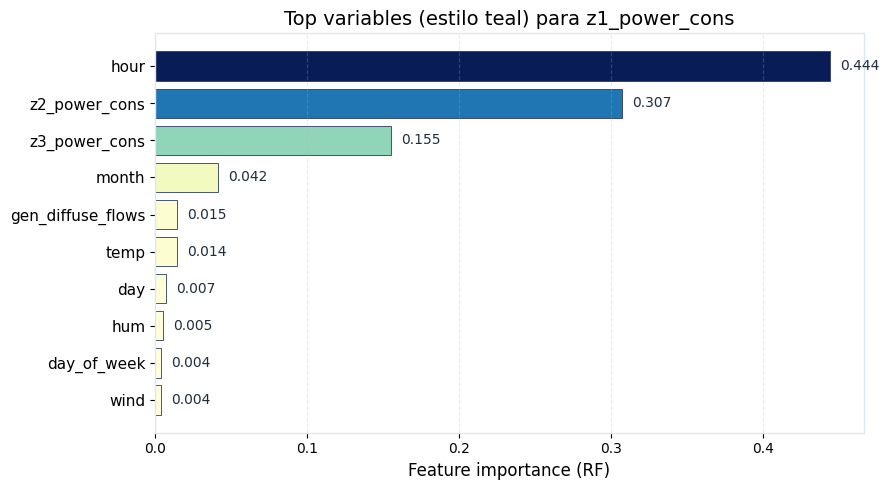

📁 Guardados en Drive:
- /content/drive/MyDrive/MLOPs/feature_importances_teal_20251012_132821.png
- /content/drive/MyDrive/MLOPs/feature_importances_20251012_132821.csv


In [10]:
# === Importancias de variables (estilo teal/azules, atractivo) ===
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from sklearn.inspection import permutation_importance
import os, time

plt.rcParams.update({
    "figure.figsize": (9, 5),
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 11,
    "axes.edgecolor": "#E0E6ED",
    "axes.linewidth": 1.0
})

# Paleta en tonos como el heatmap (elige una)
CMAP_NAME = "YlGnBu"   # alternativas: "PuBuGn", "GnBu"
cmap = plt.get_cmap(CMAP_NAME)

def show_feature_importances_pretty(estimator, X_te, y_te, topn=10, title="Top variables para z1_power_cons"):
    # 1) Importancias
    if hasattr(estimator.named_steps.get("model", estimator), "feature_importances_"):
        model = estimator.named_steps.get("model", estimator)
        vals = model.feature_importances_
        label_x = "Feature importance (RF)"
    else:
        r = permutation_importance(estimator, X_te, y_te, n_repeats=5,
                                   scoring="r2", n_jobs=-1, random_state=42)
        vals = r.importances_mean
        label_x = "Permutation importance (ΔR² medio)"

    ser = pd.Series(vals, index=X.columns, name="importance").sort_values(ascending=False)
    top = ser.head(topn)

    # 2) Tabla (Top-N)
    display(top.to_frame().style.format({"importance": "{:.4f}"}).set_caption(f"Top {topn} importancias"))

    # 3) Gráfico (colores degradados teal/azules)
    figs = plt.figure()
    ax = figs.add_subplot(111)
    y = top.index[::-1]
    x = top.values[::-1]

    # Degradado de color con normalización
    norm = Normalize(vmin=float(top.min()), vmax=float(top.max()))
    colors = [cmap(norm(v)) for v in x]

    bars = ax.barh(y, x, color=colors, edgecolor="#2B3A67", linewidth=0.6)

    # Etiquetas numéricas
    for b, v in zip(bars, x):
        ax.text(b.get_width() + (top.max()*0.015), b.get_y()+b.get_height()/2,
                f"{v:.3f}", va="center", ha="left", fontsize=10, color="#1F2D3D")

    ax.set_xlabel(label_x)
    ax.set_title(title)
    ax.grid(axis="x", linestyle="--", alpha=0.25)
    plt.tight_layout()
    plt.show()

    # 4) Guardar PNG/CSV en Drive si 'path' existe
    if "path" in globals() and os.path.isdir(path):
        ts = time.strftime("%Y%m%d_%H%M%S")
        png_fp = os.path.join(path, f"feature_importances_teal_{ts}.png")
        csv_fp = os.path.join(path, f"feature_importances_{ts}.csv")
        ser.to_csv(csv_fp)

        # Re-dibujar y guardar (para no guardar el render interactivo)
        figs = plt.figure(figsize=(9,5))
        ax = figs.add_subplot(111)
        bars = ax.barh(y, x, color=colors, edgecolor="#2B3A67", linewidth=0.6)
        ax.set_xlabel(label_x); ax.set_title(title); ax.grid(axis="x", linestyle="--", alpha=0.25)
        plt.tight_layout(); plt.savefig(png_fp, dpi=150, bbox_inches="tight"); plt.close(figs)
        print(f"📁 Guardados en Drive:\n- {png_fp}\n- {csv_fp}")

# Ejecutar
best_rf = rf_best
show_feature_importances_pretty(best_rf, X_test, y_test, topn=10,
                                title="Top variables (estilo teal) para z1_power_cons")


# 5) Tablas finales para el informe

In [12]:
def fmt(df_):
    out = df_.copy()
    for c in ["MAE","RMSE"]:
        out[c] = out[c].map(lambda v: f"{v:,.2f}")
    out["R²"] = out["R²"].map(lambda v: f"{v:.3f}")
    return out

print("🔹 Resultados baseline")
display(fmt(baseline))

print("🔹 Mejores modelos (tuning rápido)")
display(fmt(summary.drop(columns=["Best Params"])))

print("🔹 Hiperparámetros óptimos")
summary[["Modelo","Best Params"]]




🔹 Resultados baseline


,Modelo,MAE,RMSE,R²
0,RF,650.65,932.59,0.983
1,Linear,"2,041.04","2,626.27",0.863
2,Lasso,"2,041.04","2,626.27",0.863
3,Ridge,"2,041.04","2,626.27",0.863


🔹 Mejores modelos (tuning rápido)


,Modelo,MAE,RMSE,R²
0,RandomForest (tuned),548.17,834.14,0.986
1,Ridge (tuned),"2,041.77","2,627.07",0.863


🔹 Hiperparámetros óptimos


,Modelo,Best Params
0,RandomForest (tuned),"{'model__n_estimators': 180, 'model__min_sampl..."
1,Ridge (tuned),{'model__alpha': 1.0}
